<a href="https://colab.research.google.com/github/tamirhouri/phishing-detector-chrome-extension/blob/main/url-detector-model/PhishingDetectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing detectors - Chrome extension

## Prerequisite

### Install Dependencies

In [ ]:
!pip install tensorflow tensorflowjs pandas scikit-learn --quiet

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import shutil
import re
from urllib.parse import urlparse
import ipaddress
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Utils

### URL Feature Extractor

In [ ]:
class UrlFeaturesExtractor:
    SHORTENING_SERVICES = {
        "bit.ly", "tinyurl.com", "goo.gl", "ow.ly", "t.co", "is.gd", "bitly.com",
        "vzturl.com", "qr.net", "1url.com", "tweez.me", "v.gd", "tr.im", "link.zip.net",
        "filoops.info"
    }

    SUSPICIOUS_WORDS = {
        "login", "verify", "account", "password", "bank", "secure",
        "free", "lucky", "service", "bonus", "ebayisapi", "webscr",
        "paypal", "signin", "update"
    }

    UNCOMMON_TLDS = {'.tk', '.ml', '.ga', '.cf', '.gq'}

    BRANDS = {
        # finance / payments
        'paypal', 'visa', 'mastercard', 'stripe', 'square', 'bankofamerica',
        # tech giants
        'google', 'gmail', 'youtube', 'android', 'chrome', 'facebook',
        'instagram', 'whatsapp', 'meta', 'apple', 'icloud', 'mac', 'itunes',
        'amazon', 'aws', 'microsoft', 'office365', 'outlook', 'live', 'onedrive',
        'windows', 'github', 'gitlab', 'bitbucket', 'dropbox',
        # social & comms
        'twitter', 'x.com', 'tiktok', 'snapchat', 'linkedin', 'slack', 'zoom',
        # entertainment / services
        'netflix', 'hulu', 'disney', 'spotify', 'steam', 'epicgames',
        # e‑commerce & others
        'ebay', 'etsy', 'shopify', 'alibaba', 'yahoo', 'proton', 'adobe'
    }

    WHITELIST = {
        # tech giants
        'google.com',      'youtube.com',     'gmail.com',
        'facebook.com',    'instagram.com',   'whatsapp.com',  'meta.com',
        'apple.com',       'icloud.com',
        'amazon.com',      'aws.amazon.com',
        'microsoft.com',   'office.com',      'live.com',      'outlook.com',
        'github.com',      'gitlab.com',      'bitbucket.org', 'dropbox.com',
        # finance / payments
        'paypal.com',      'stripe.com',      'visa.com',      'mastercard.com',
        # social & comms
        'twitter.com',     'tiktok.com',      'snapchat.com',  'linkedin.com',
        'slack.com',       'zoom.us',
        # entertainment / services
        'netflix.com',     'hulu.com',        'disneyplus.com',
        'spotify.com',     'steampowered.com','epicgames.com',
        # e‑commerce
        'ebay.com',        'etsy.com',        'shopify.com',   'alibaba.com',
        # security / privacy
        'proton.me',       'protonmail.com',
        # misc
        'yahoo.com',       'adobe.com'
    }

    def __init__(self, url: str):
        self.url = url
        self.parsed = urlparse(url)

    def get_length(self) -> int:
        return len(self.url)

    def hostname_length(self) -> int:
        return len(self.parsed.hostname or '')

    def has_at_symbol(self) -> int:
        return int('@' in self.url)

    def dot_count(self) -> int:
        return self.url.count('.')

    def hyphen_count(self) -> int:
        return self.url.count('-')

    def count_special_chars(self):
        return sum(self.url.count(c) for c in ['@', '=', '&', '#', '?', '%', '+'])

    def is_https(self) -> int:
        return int(self.parsed.scheme.lower() == 'https')

    def path_length(self) -> int:
        return len(self.parsed.path)

    def query_length(self) -> int:
        return len(self.parsed.query)

    def fragment_length(self) -> int:
        return len(self.parsed.fragment)

    def port_length(self) -> int:
        return 0 if self.parsed.port is None else len(str(self.parsed.port))

    def has_redirection(self) -> int:
        stripped_url = self.url.replace('http://', '').replace('https://', '', 1)
        return int('//' in stripped_url)

    def url_path_depth(self) -> int:
        return sum(1 for part in self.parsed.path.split('/') if part)

    def digit_count(self) -> int:
        return sum(char.isdigit() for char in self.url)

    def has_shortening_service(self) -> int:
        if not self.parsed.hostname:
            return 0
        host = self.parsed.hostname.lower()

        # Exact match  ➜  bit.ly   == bit.ly
        if host in self.SHORTENING_SERVICES:
            return 1

        # Sub‑domain of a known shortener ➜  x.bit.ly
        return int(any(host.endswith('.' + svc) for svc in self.SHORTENING_SERVICES))

    def has_ip_address(self) -> int:
        try:
            ipaddress.ip_address(self.parsed.hostname)
            return 1
        except (ValueError, TypeError):
            return 0

    def subdomain_count(self) -> int:
        if not self.parsed.hostname or self.has_ip_address():
            return 0
        return max(0, len(self.parsed.hostname.split('.')) - 2)

    def has_suspicious_words(self) -> int:
        return int(any(word in self.url.lower() for word in self.SUSPICIOUS_WORDS))

    def uncommon_tld(self):
        if not self.parsed.hostname:
            return 0
        return int(any(self.parsed.hostname.endswith(tld) for tld in self.UNCOMMON_TLDS))

    def contains_brand_name(self) -> int:
        """1 if the URL string contains any well‑known brand name."""
        u = self.url.lower()
        return int(any(brand in u for brand in self.BRANDS))

    def is_known_domain(self) -> int:
        """
        1 if the hostname is on a whitelisted domain (exact match or sub‑domain).
        Helps the model avoid flagging legitimate services.
        """
        host = (self.parsed.hostname or '').lower()
        return int(
            host in self.WHITELIST or
            any(host.endswith('.' + dom) for dom in self.WHITELIST)
        )

    def extract_all(self) -> list[float]:
        features = [
            self.get_length(),
            self.dot_count(),
            self.hyphen_count(),
            self.is_https(),
            self.hostname_length(),
            self.path_length(),
            self.query_length(),
            self.port_length(),
            self.has_redirection(),
            self.url_path_depth(),
            self.digit_count(),
            self.has_shortening_service(),
            self.has_ip_address(),
            self.subdomain_count(),
            self.has_suspicious_words(),
            self.count_special_chars(),
            self.uncommon_tld(),
            self.contains_brand_name(),
            # self.is_known_domain()
        ]

        return [float(f) for f in features]


# Data Processing

In [ ]:
def build_dataset(df):
    X = np.array([UrlFeaturesExtractor(url).extract_all() for url in df['url']])
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)
    y = df['status'].values.astype('int64')
    return X, y

## Data Preprocessing 1

### Loading

In [ ]:
kaggle_dataset_path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

dataset_path = "/content/phishing_dataset"
dataset_name = "dataset_phishing.csv"
shutil.copytree(kaggle_dataset_path, dataset_path, dirs_exist_ok=True)

print("Path to dataset files:", dataset_path)

Path to dataset files: /content/phishing_dataset


In [ ]:
df_data = pd.read_csv(f"{dataset_path}/{dataset_name}")
df_data.shape

(11430, 89)

In [ ]:
df_data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
print("Safe URLs:", df_data[df_data["status"]=="legitimate"].shape[0])
print("Phishing URLs:", df_data[df_data["status"]=="phishing"].shape[0])

Safe URLs: 5715
Phishing URLs: 5715


### Proccesing

In [ ]:
df_data.loc[df_data["status"] == "legitimate", "status"] = 0
df_data.loc[df_data["status"] == "phishing", "status"] = 1

### Build Dataset

In [ ]:
X_1, y_1 = build_dataset(df_data)

## Dataset Preprocessing 2

### Loading

In [ ]:
kaggle_dataset_path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")
dataset_path = "/content/phishing_dataset2"
dataset_name = "malicious_phish.csv"
shutil.copytree(kaggle_dataset_path, dataset_path, dirs_exist_ok=True)

print("Path to dataset files:", dataset_path)

Path to dataset files: /content/phishing_dataset2


In [ ]:
df_data = pd.read_csv(f"{dataset_path}/{dataset_name}")
df_data.shape

(651191, 2)

In [ ]:
df_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# remove non phishing or benign urls
df_data = df_data[df_data["type"].isin(["benign", "phishing"])]
df_data.shape

(522214, 2)

In [ ]:
print("Safe URLs:", df_data[df_data["type"] =="benign"].shape[0])
print("Phishing URLs:", df_data[df_data["type"] !="benign"].shape[0])

Safe URLs: 428103
Phishing URLs: 94111


### Processing

In [ ]:
df_data.loc[df_data["type"] == "benign", "status"] = 0
df_data.loc[df_data["type"] != "benign", "status"] = 1

### Build Dataset

In [ ]:
X_2, y_2 = build_dataset(df_data)

## Dataset Preprocessing 3

### Loading

In [ ]:
# kaggle_dataset_path = kagglehub.dataset_download("taruntiwarihp/phishing-site-urls")
# dataset_path = "/content/phishing_dataset3"
# dataset_name = "phishing_site_urls.csv"
# shutil.copytree(kaggle_dataset_path, dataset_path, dirs_exist_ok=True)

# print("Path to dataset files:", dataset_path)

In [ ]:
# df_data = pd.read_csv(f"{dataset_path}/{dataset_name}")
# df_data.shape

In [ ]:
# df_data.head()

### Processing

In [ ]:
# df_data.loc[df_data["Label"] == "good", "status"] = 0
# df_data.loc[df_data["Label"] != "good", "status"] = 1
# df_data.rename(columns={'URL': 'url'}, inplace=True)

### Build Dataset

In [ ]:
# X_3, y_3 = build_dataset(df_data)

## Merge Datasets

In [ ]:
X = np.concatenate((X_1, X_2), axis=0)
y = np.concatenate((y_1, y_2), axis=0)
# X = np.concatenate((X_1, X_2, X_3), axis=0)
# y = np.concatenate((y_1, y_2, y_3), axis=0)
X.shape, y.shape

((533644, 18), (533644,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
# X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# print("X_train_1 shape:", X_train_1.shape)
# print("y_train_1 shape:", y_train_1.shape)
# print("X_test_1 shape:", X_test_1.shape)
# print("y_test_1 shape:", y_test_1.shape)
# print("X_train_2 shape:", X_train_2.shape)
# print("y_train_2 shape:", y_train_2.shape)
# print("X_test_2 shape:", X_test_2.shape)
# print("y_test_2 shape:", y_test_2.shape)
# print("X_train_3 shape:", X_train_3.shape)
# print("y_train_3 shape:", y_train_3.shape)
# print("X_test_3 shape:", X_test_3.shape)
# print("y_test_3 shape:", y_test_3.shape)

X_train shape: (426915, 18)
y_train shape: (426915,)
X_test shape: (106729, 18)
y_test shape: (106729,)


### Correlation

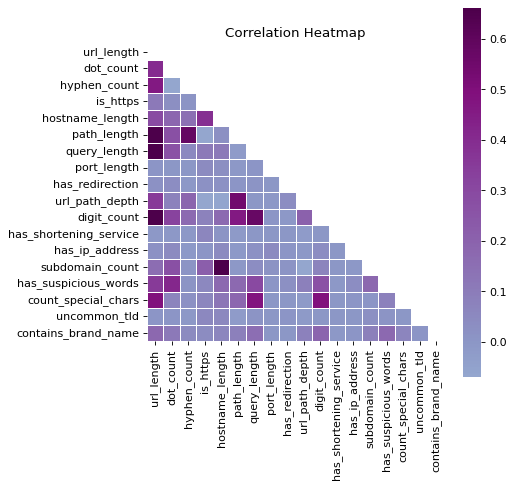

In [ ]:
fig = plt.figure(figsize=(6,6),dpi=80)
corr_df = pd.DataFrame(X_train)
corr_df.columns = ['url_length', 'dot_count', 'hyphen_count', 'is_https', 'hostname_length', 'path_length',
                   'query_length', 'port_length', 'has_redirection', 'url_path_depth', 'digit_count',
                   'has_shortening_service', 'has_ip_address', 'subdomain_count', 'has_suspicious_words', 'count_special_chars',
                   'uncommon_tld', 'contains_brand_name']
# corr_df.columns = ['url_length', 'dot_count', 'hyphen_count', 'is_https', 'hostname_length', 'path_length',
#                    'query_length', 'port_length', 'has_redirection', 'url_path_depth', 'digit_count',
#                    'has_shortening_service', 'has_ip_address', 'subdomain_count', 'has_suspicious_words', 'count_special_chars',
#                    'uncommon_tld', 'contains_brand_name', 'is_known_domain']
corr_matrix = corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

model = tf.keras.Sequential([
       tf.keras.layers.Input(shape=(X_train.shape[1],)),
      normalizer,
       tf.keras.layers.Dense(32, activation='relu'),
      #  tf.keras.layers.Dropout(0.3),
      #  tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(16, activation='relu'),
      #  tf.keras.layers.Dropout(0.3),
      #  tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(8, activation='relu'),
      #  tf.keras.layers.Dropout(0.3),
      #  tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(1, activation='sigmoid')
   ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_34                │ (None, 18)             │            37 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,318 (5.15 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 37 (152.00 B)

## Train

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=500)
# history = model.fit(X_train_1, y_train_1, validation_data=(X_test_1, y_test_1), epochs=50, batch_size=32)
# history = model.fit(X_train_2, y_train_2, validation_data=(X_test_2, y_test_2), epochs=30, batch_size=50)
# history = model.fit(X_train_3, y_train_3, validation_data=(X_test_3, y_test_3), epochs=30, batch_size=50)

Epoch 1/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8424 - loss: 0.3946 - val_accuracy: 0.8683 - val_loss: 0.2886
Epoch 2/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8722 - loss: 0.2864 - val_accuracy: 0.8788 - val_loss: 0.2793
Epoch 3/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8779 - loss: 0.2790 - val_accuracy: 0.8793 - val_loss: 0.2758
Epoch 4/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8802 - loss: 0.2742 - val_accuracy: 0.8820 - val_loss: 0.2703
Epoch 5/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8819 - loss: 0.2700 - val_accuracy: 0.8834 - val_loss: 0.2679
Epoch 6/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8829 - loss: 0.2676 - val_accuracy: 0.8824 - val_loss: 0.2663
Epoch 7/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8832 - loss: 0.2656 - val_accuracy: 0.8841 - val_loss: 0.2652
Epoch 8/20
854/854 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8841 - loss: 0.2650 - val_accuracy: 0.

## Evaluation

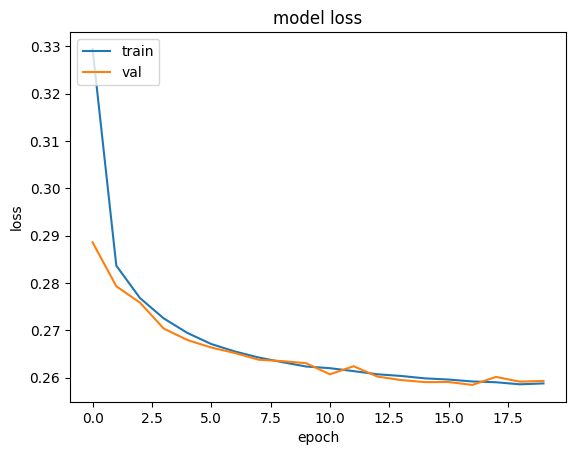

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

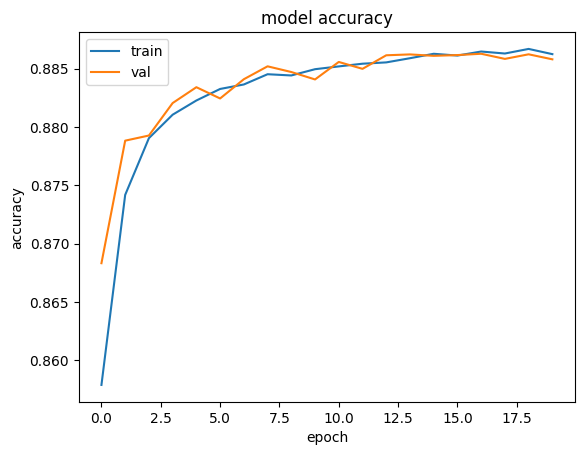

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# XGBoost Model

In [ ]:
# create a xgboost model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.45).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     86710
           1       0.81      0.56      0.66     20019

    accuracy                           0.89    106729
   macro avg       0.86      0.77      0.80    106729
weighted avg       0.89      0.89      0.89    106729



In [ ]:
# y_pred = model.predict(X_test_1)
# y_pred = (y_pred > 0.63).astype(int)
# print(classification_report(y_test_1, y_pred))

3336/3336 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Best threshold: 0.1929


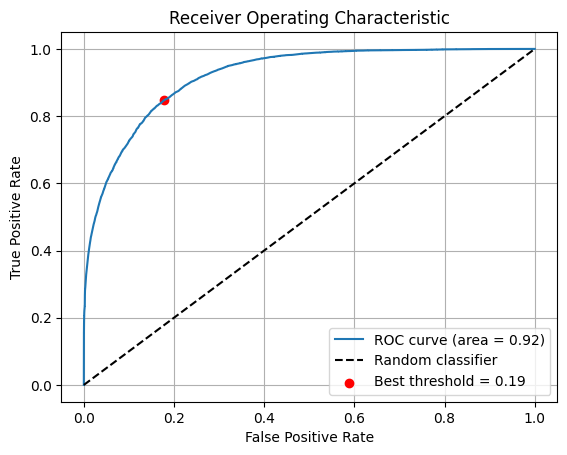

In [ ]:
y_pred_prob = model.predict(X_test).ravel()  # Flatten to shape (n_samples,)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

import numpy as np

j_scores = tpr - fpr
best_index = np.argmax(j_scores)
best_threshold = thresholds[best_index]

print(f"Best threshold: {best_threshold:.4f}")


import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
plt.scatter(fpr[best_index], tpr[best_index], color='red', label=f"Best threshold = {best_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# y_pred = model.predict(X_test)
# y_pred = (y_pred > 0.26).astype(int)
# print(classification_report(y_test, y_pred))

### Evaluate on different dataset

In [ ]:
# y_pred = model.predict(X_3)
# y_pred = (y_pred > 0.5).astype(int)
# print(classification_report(y_3, y_pred))

### Tests

In [ ]:
# get all urls in dataset which has the word 'google'
google_df = df_data[df_data['url'].str.contains('google')]
# get 11 row
google_df
# google_df

,url,type,status
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,1.0
187,http://drive-google-com.fanalav.com/6a7ec96d6a...,phishing,1.0
676,sites.google.com/a/woodplanning.com/www/,benign,0.0
894,google.com/hostednews/afp/article/ALeqM5iK8qoG...,benign,0.0
1807,groups.google.com/group/alt.conspiracy.jfk/bro...,benign,0.0
...,...,...,...
648455,froods.ca/~dschaub/google.html,phishing,1.0
648501,sites.google.com/site/ucdgamesoc/,phishing,1.0
649690,sites.google.com/site/aaronellery/,phishing,1.0
649892,sites.google.com/site/nichiyasei/,phishing,1.0


In [ ]:
# corr_df.columns = ['url_length', 'dot_count', 'hyphen_count', 'is_https', 'hostname_length', 'path_length',
#                    'query_length', 'port_length', 'has_redirection', 'url_path_depth', 'digit_count',
#                    'has_shortening_service', 'has_ip_address', 'subdomain_count', 'has_suspicious_words', 'count_special_chars',
#                    'uncommon_tld', 'contains_brand_name', 'is_known_domain']

In [ ]:
url = "www.israel.com"
features = UrlFeaturesExtractor(url).extract_all()
features = np.array([features])
res = model.predict(features)
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
[[0.3961131]]


### Shap Evaluation

In [ ]:
# import shap
# feature_names = ['url_length', 'has_at_symbol', 'dot_count', 'has_hyphen', 'is_https', 'hostname_length', 'path_length',
#                       'query_length', 'fragment_length', 'port_length', 'has_redirection', 'url_path_depth', 'digit_count',
#                       'has_shortening_service', 'has_ip_address', 'subdomain_count', 'has_suspicious_words', 'count_special_chars',
#                       'uncommon_tld']

# explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 50))
# shap_values = explainer.shap_values(X_test[:5])

In [ ]:
# # 5. Plot SHAP summary
# shap.summary_plot(shap_values, X_test[:5], feature_names=feature_names)

In [ ]:
# shap.plots.waterfall(
#     shap.Explanation(
#         values=shap_values[0][0],                   # SHAP values for 1st instance
#         base_values=explainer.expected_value[0],    # Expected model output
#         data=X_test[0],                             # Feature values for 1st instance
#         feature_names=feature_names
#     )
# )

In [ ]:
# shap.summary_plot(
#     shap_values,                  # e.g., shap_values[0] for binary classifier
#     X_test[:5],                  # or full X_test if it's small
#     feature_names=feature_names
# )

## Export

Save model in TensorFlow format

In [ ]:
model.export("url_model_tf")

Saved artifact at 'url_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor_53')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136457124147088: TensorSpec(shape=(1, 17), dtype=tf.float32, name=None)
  136457124147856: TensorSpec(shape=(1, 17), dtype=tf.float32, name=None)
  136457124150160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136457124146320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136457124146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136457124144592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136457124146896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136457124145168: TensorSpec(shape=(), dtype=tf.resource, name=None)


Convert to TensorFlow.js format

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model url_model_tf ./tfjs_url_model

2025-04-18 11:38:23.089284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744976303.115710   65936 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744976303.123202   65936 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-18 11:38:29.048303: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1744976309.146532   65936 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
# !rm -rf url_model_tf tfjs_url_model model